# BTC

- BTC Analysis
- BTC Prediction using ML

In [75]:
# 필요한 라이브러리를 읽어오기
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Activation
from keras.layers import Dropout
from keras.models import load_model
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
py.init_notebook_mode(connected=True)
%matplotlib inline

In [76]:
# 데이터 읽어오기
df_master = pd.read_csv(filepath_or_buffer="../data/CRIX.UPBIT.KRW-BTC_2017-11-01_2018-01-22.csv")
df_master['date'] = pd.to_datetime(df_master['date'],unit='ms') # 날짜 변환
df_master = df_master.set_index('date'); # date 를 인덱스로 설정

In [102]:
# 데이터 훑어보기
print(df_master.info()) # basic info
print(df_master.head(3)) # print first 3 rows
print(df_master.isnull().any())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 119400 entries, 2017-10-31 20:26:00 to 2018-01-22 12:22:00
Data columns (total 6 columns):
low                119400 non-null float64
high               119400 non-null float64
open               119400 non-null float64
close              119400 non-null float64
volume             119400 non-null float64
weightedAverage    119400 non-null float64
dtypes: float64(6)
memory usage: 6.4 MB
None
                           low       high       open      close    volume  \
date                                                                        
2017-10-31 20:26:00  7259000.0  7259000.0  7259000.0  7259000.0  0.014000   
2017-10-31 20:27:00  7259000.0  7259000.0  7259000.0  7259000.0  0.007000   
2017-10-31 20:28:00  7259000.0  7259000.0  7259000.0  7259000.0  0.006832   

                     weightedAverage  
date                                  
2017-10-31 20:26:00     101626.00000  
2017-10-31 20:27:00      50813.00000  
2017-10-31 

In [127]:
# 1분 데이터를 15분 데이터로 변경
df_open =  df_master['open'].resample('15Min').ohlc()
df_open.fillna(method='ffill', inplace=True)

df_volume = df_master['volume'].resample('15Min').sum()
df_volume.replace([0, np.inf], np.nan, inplace=True)
df_volume.fillna(method='ffill', inplace=True)

df = pd.concat([df_open, df_volume], axis=1)

print(df.info())
print(df.head(3))
print(df.isnull().any())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7937 entries, 2017-10-31 20:15:00 to 2018-01-22 12:15:00
Freq: 15T
Data columns (total 5 columns):
open      7937 non-null float64
high      7937 non-null float64
low       7937 non-null float64
close     7937 non-null float64
volume    7937 non-null float64
dtypes: float64(5)
memory usage: 692.0 KB
None
                          open       high        low      close    volume
date                                                                     
2017-10-31 20:15:00  7259000.0  7259000.0  7259000.0  7259000.0  0.041832
2017-10-31 20:30:00  7259000.0  7280000.0  7254000.0  7280000.0  4.087197
2017-10-31 20:45:00  7280000.0  7300000.0  7280000.0  7300000.0  1.706915
open      False
high      False
low       False
close     False
volume    False
dtype: bool


In [128]:
# 캔들 그래프는 메모리를 많이 먹는지 느려진다 ㅠㅠ
'''
trace = go.Ohlc(x=df.index,
                open=df.open,
                high=df.high,
                low=df.low,
                close=df.close)
py.iplot([trace])
'''

# 시가 그래프만 그려보자 
trace = go.Scatter(x=df.index, y=df.open)
py.iplot([trace])

## 학습 시켜보자

학습을 단순화 시키기 위해 시가(open) 값만 사용해서 학습 모델을 만들어보자. 

Time-series 데이터이기에 LSTM(Long short-term memory)를 사용해보자.

In [138]:
# 그래프를 보면 2017년말까지 increasing trend 를 볼 수 있다. (2018부터는 떨어지는 추세...?)
# 이대로 학습 시킬 경우 학습 모델은 경험하지 못한 새로운 가격을 예측해야 한다는 어려움이 생긴다.
# 따라서 rate of change 기준으로 학습을 시켜보자

roc_open = df['open'].pct_change() # calculate rate of change
roc_open.iloc[0] = 0.0 # first element 는 비교할 대상이 없으므로 0으로 세팅
mask = np.isnan(roc_open)
roc_open[mask] = 0 # fill with zero

roc_volume = df['volume'].pct_change()
roc_volume.iloc[0] = 0.0
mask = np.isnan(roc_volume)
roc_volume[mask] = 0 # fill with zero

df['roc_open'] = roc_open
df['roc_volume'] = roc_volume
print(df.head(3))

                          open       high        low      close    volume  \
date                                                                        
2017-10-31 20:15:00  7259000.0  7259000.0  7259000.0  7259000.0  0.041832   
2017-10-31 20:30:00  7259000.0  7280000.0  7254000.0  7280000.0  4.087197   
2017-10-31 20:45:00  7280000.0  7300000.0  7280000.0  7300000.0  1.706915   

                     roc_open  roc_volume  
date                                       
2017-10-31 20:15:00  0.000000    0.000000  
2017-10-31 20:30:00  0.000000   96.704168  
2017-10-31 20:45:00  0.002893   -0.582375  


In [141]:
trace_roc_open = go.Scatter(x=df.index, y=df['roc_open']*100) # rate of change as percentage
trace_roc_volume = go.Scatter(x=df.index, y=df['roc_volume']*100)
py.iplot([trace_roc_open])

In [142]:
# 데이터 split 하기
# 학습 데이터 0.8, 테스트 0.2
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df[0:train_size], df[train_size:len(values)]
train_idx, test_idx = df.index[0:train_size], df.index[train_size:len(values)]
print("트레이닝 데이터: ", len(train), "records")
print("테스트 데이터: ", len(test), "records")

트레이닝 데이터:  6349 records
테스트 데이터:  1588 records


In [174]:
# LSTM helper 
def create_dataset(dataset, look_back=5):
    x, y = [], []
    look_forward = 0
    for i in range(look_back, len(dataset) - look_forward):
        x_ = dataset.iloc[(i-look_back):i][["roc_open", "roc_volume"]]
        # y_ = dataset[i:(i+look_forward)]
        y_ = dataset.iloc[i][["roc_open"]]
        x.append(x_.values)
        y.append(y_.values)
    return np.array(x), np.array(y)

look_back=10
train_x, train_y = create_dataset(train, look_back)
test_x, test_y = create_dataset(test, look_back)

In [175]:
train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1], 2)) # sample size, time step, feature
test_x = np.reshape(test_x, (test_x.shape[0], test_x.shape[1], 2))
train_y = np.reshape(train_y, (train_y.shape[0],))
test_y = np.reshape(test_y, (test_y.shape[0],))

print(train_x[0].shape)
print(train_x.shape)
print(train_y.shape)

(10, 2)
(6339, 10, 2)
(6339,)


In [177]:
# 모델 생성
# TODO: hypter-parameter 값 / 좋은 network 구성은 무엇일까?
model = Sequential()
#model.add(LSTM(32, input_shape=(train_x.shape[1], train_x.shape[2]), return_sequences=True))
#model.add(LSTM(32, return_sequences=True))  # returns a sequence of vectors of dimension 32
#model.add(LSTM(32))  # return a single vector of dimension 32
#model.add(Dense(1))
#model.compile(loss='mae', optimizer='adam')

model.add(LSTM(32, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1,activation='linear'))
model.compile(optimizer='rmsprop',loss='mse')
history = model.fit(train_x, train_y, epochs=100, batch_size=100, validation_data=(test_x, test_y), verbose=1, shuffle=False)


Train on 6339 samples, validate on 1578 samples
Epoch 1/100
6339/6339 [==============================] - 8s 1ms/step - loss: 5.0949e-04 - val_loss: 2.5990e-04
Epoch 2/100
6339/6339 [==============================] - 2s 302us/step - loss: 3.1652e-04 - val_loss: 2.4657e-04
Epoch 3/100
6339/6339 [==============================] - 2s 289us/step - loss: 2.6265e-04 - val_loss: 2.7784e-04
Epoch 4/100
6339/6339 [==============================] - 2s 270us/step - loss: 2.8366e-04 - val_loss: 2.3845e-04
Epoch 5/100
6339/6339 [==============================] - 2s 252us/step - loss: 1.9225e-04 - val_loss: 2.4869e-04
Epoch 6/100
6339/6339 [==============================] - 2s 250us/step - loss: 2.1319e-04 - val_loss: 2.5936e-04
Epoch 7/100
6339/6339 [==============================] - 2s 256us/step - loss: 1.8289e-04 - val_loss: 2.4424e-04
Epoch 8/100
6339/6339 [==============================] - 2s 311us/step - loss: 1.8014e-04 - val_loss: 2.4243e-04
Epoch 9/100
6339/6339 [===========================

6339/6339 [==============================] - 1s 224us/step - loss: 9.9156e-05 - val_loss: 2.4877e-04
Epoch 73/100
6339/6339 [==============================] - 2s 264us/step - loss: 9.9109e-05 - val_loss: 2.4971e-04
Epoch 74/100
6339/6339 [==============================] - 2s 243us/step - loss: 9.9078e-05 - val_loss: 2.4798e-04
Epoch 75/100
6339/6339 [==============================] - 1s 219us/step - loss: 9.9000e-05 - val_loss: 2.4829e-04
Epoch 76/100
6339/6339 [==============================] - 2s 290us/step - loss: 9.8995e-05 - val_loss: 2.4730e-04
Epoch 77/100
6339/6339 [==============================] - 2s 280us/step - loss: 9.8902e-05 - val_loss: 2.4745e-04
Epoch 78/100
6339/6339 [==============================] - 1s 229us/step - loss: 9.8618e-05 - val_loss: 2.4863e-04
Epoch 79/100
6339/6339 [==============================] - 1s 213us/step - loss: 9.8500e-05 - val_loss: 2.4984e-04
Epoch 80/100
6339/6339 [==============================] - 2s 275us/step - loss: 9.8681e-05 - val_loss

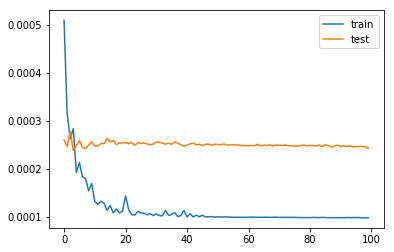

In [178]:
# Training Error 를 그려보자
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [179]:
# Prediction
pred_y = model.predict(test_x)

# Restore from min max scaler
#pred_y_onestep = scaler.inverse_transform(pred_y.reshape(-1, 1))
#test_y_onestep = scaler.inverse_transform(test_y.reshape(-1, 1))
pred_y_onestep = np.reshape(pred_y, (-1, 1))
test_y_onestep = np.reshape(test_y, (-1, 1)) 

In [182]:
df_test = df[train_size:len(df)]
print(len(df_test))
print(len(test))
print(len(pred_y_onestep))
print(len(test_y_onestep))

# 예측 값 복원하기 
pred_open = []
for i in range(len(pred_y_onestep)):
    j = look_back + i - 1
    pred_open.append(df_test.iloc[j]['open'] * (1.00 + pred_y_onestep[i]))
    # pred_open.append(df_test.iloc[j]['open'] * (1.00 + test_y_onestep[i]))


# 테스트 데이터
df_test_pred = pd.DataFrame(df_test.iloc[-len(pred_y_onestep):])
df_test_pred["open_pred"] = np.array(pred_open)

# 그래프 그려보기
trace_real = go.Scatter(x=df_test_pred.index, y=df_test_pred["open"], name="Real") # real
trace_pred = go.Scatter(x=df_test_pred.index, y=df_test_pred["open_pred"], name="Prediction") # pred
py.iplot([trace_real, trace_pred])

1588
1588
1578
1578


In [183]:
rmse = sqrt(mean_squared_error(test_y_onestep, pred_y_onestep))
print('Test RMSE: %.3f' % rmse)

tf = [t*p > 0 for t, p in zip(test_y_onestep, pred_y_onestep)]
print('Accuracy: %.3f' % (sum(tf) / len(tf)))


Test RMSE: 0.016
Accuracy: 0.504


In [47]:
model.save('./btc_model.h5')

Acknowledgement: 
  - https://www.kaggle.com/jphoon/bitcoin-time-series-prediction-with-lstm
  - https://stackoverflow.com/questions/43034960/many-to-one-and-many-to-many-lstm-examples-in-keras
  - https://github.com/keras-team/keras/issues/6063
  - https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/